<a href="https://colab.research.google.com/github/divsal009/div/blob/master/Tumor_Classification_and_Localization_Deep_Learning_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
pip install mat4py


https://github.com/srinidhig/tumor_classification_localization

In [46]:
pip install mat73

In [47]:
import os
from mat4py import loadmat
import h5py
import tables
import mat73
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import cv2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from scipy import ndimage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_curve, auc

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/dataset1'):
  os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset1')


In [50]:
import zipfile

In [51]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/dataset1/data.zip') as zf:
  zip_dir = zf.namelist()[0]
  zf.extractall('/content/drive/My Drive/Colab Notebooks/dataset1')

In [52]:
!ls '/content/drive/My Drive/Colab Notebooks/dataset1/'

brainTumorDataPublic_1533-2298.zip  cvind.mat
brainTumorDataPublic_1-766.zip	    data.zip
brainTumorDataPublic_2299-3064.zip  README.txt
brainTumorDataPublic_767-1532.zip


In [53]:
!cat '/content/drive/My Drive/Colab Notebooks/dataset1/README.txt'

This brain tumor dataset containing 3064 T1-weighted contrast-inhanced images
from 233 patients with three kinds of brain tumor: meningioma (708 slices), 
glioma (1426 slices), and pituitary tumor (930 slices). Due to the file size
limit of repository, we split the whole dataset into 4 subsets, and achive 
them in 4 .zip files with each .zip file containing 766 slices.The 5-fold
cross-validation indices are also provided.

-----
This data is organized in matlab data format (.mat file). Each file stores a struct
containing the following fields for an image:

cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
cjdata.PID: patient ID
cjdata.image: image data
cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border.
		For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
		It was generated by manually delineating the tumor border. So we can use it to generate
		binary image of tumor mask.
cjdata.tumorMask: a

In [54]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/dataset1/brainTumorDataPublic_1-766.zip') as zf:
  os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set1')
  zip_dir = zf.namelist()[0]
  zf.extractall('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set1')

In [55]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/dataset1/brainTumorDataPublic_767-1532.zip') as zf:
  os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set2')
  zip_dir = zf.namelist()[0]
  zf.extractall('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set2')

In [56]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/dataset1/brainTumorDataPublic_1533-2298.zip') as zf:
  os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set3')
  zip_dir = zf.namelist()[0]
  zf.extractall('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set3')

In [57]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/dataset1/brainTumorDataPublic_2299-3064.zip') as zf:
  os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set4')
  zip_dir = zf.namelist()[0]
  zf.extractall('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set4')

In [58]:
os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset1/imageData')


In [59]:
data1 = '/content/drive/MyDrive/Colab Notebooks/dataset1/bt_set1/'
data2 = '/content/drive/MyDrive/Colab Notebooks/dataset1/bt_set2/'
data3 = '/content/drive/MyDrive/Colab Notebooks/dataset1/bt_set3/'
data4 = '/content/drive/MyDrive/Colab Notebooks/dataset1/bt_set4/'

In [60]:
# Read the data

patient_ids = []
images = []
labels = []
tumorBorders = []
tumorMask = []

def populate_lists(data1):
    for d in os.listdir(data1):
        mat = mat73.loadmat(data1 + d)
        patient_ids.append(mat['cjdata']['PID'])
        images.append(mat['cjdata']['image'])
        labels.append(int(mat['cjdata']['label']))
        tumorBorders.append(mat['cjdata']['tumorBorder'])
        tumorMask.append(mat['cjdata']['tumorMask'])
    return patient_ids, images, labels, tumorBorders, tumorMask

patient_ids, images, labels, tumorBorders, tumorMask = populate_lists(data1)
patient_ids, images, labels, tumorBorders, tumorMask = populate_lists(data2)
patient_ids, images, labels, tumorBorders, tumorMask = populate_lists(data3)
patient_ids, images, labels, tumorBorders, tumorMask = populate_lists(data4)

In [61]:
patient_ids[0]

'100360'

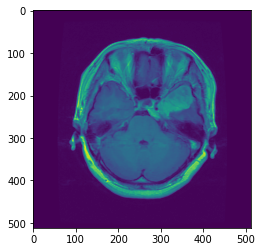

In [62]:
plt.imshow(images[0])

In [64]:
labels[0]

1

In [65]:
tumorBorders[0]

array([267.61524501, 231.37568058, 277.83666062, 248.10163339,
       289.91651543, 250.8892922 , 305.71324864, 253.676951  ,
       318.72232305, 249.9600726 , 321.50998185, 237.88021779,
       354.96188748, 234.16333938, 367.97096189, 227.65880218,
       380.9800363 , 210.93284936, 372.61705989, 195.13611615,
       363.32486388, 177.48094374, 350.31578947, 176.55172414,
       336.37749546, 183.98548094, 317.79310345, 196.06533575,
       305.71324864, 207.21597096, 295.49183303, 217.43738657,
       288.98729583, 222.08348457, 273.19056261, 223.94192377,
       268.54446461, 228.58802178])

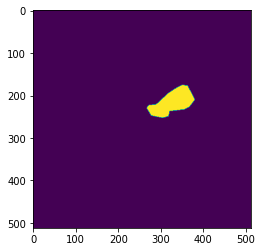

In [66]:
plt.imshow(tumorMask[0])

In [67]:
# Exploratory Analysis on Data

# Number of total samples
print('Number of total samples: ' + str(len(patient_ids)))

# Number of unique patients
print('Number of unique patients we have samples for: ' + str(len(set(patient_ids))))

# What are the unique class labels
print('Unique Class Labels: ' + str(set(labels)))

# Frequency of class labels
print('Frequency Class Labels: ' + str({x:labels.count(x) for x in labels}))
print('Class 1 is Meningioma, Class 2 is Glioma, Class 3 is Pituitary Tumor')

Number of total samples: 3064
Number of unique patients we have samples for: 233
Unique Class Labels: {1, 2, 3}
Frequency Class Labels: {1: 708, 2: 1426, 3: 930}
Class 1 is Meningioma, Class 2 is Glioma, Class 3 is Pituitary Tumor


In [68]:
# What do the individual tumors look like?

ind_1 = []
ind_2 = []
ind_3 = []

for ind in range(len(labels)):
    if labels[ind] == 1:
        ind_1.append(ind)
    elif labels[ind] == 2:
        ind_2.append(ind)
    else:
        ind_3.append(ind)

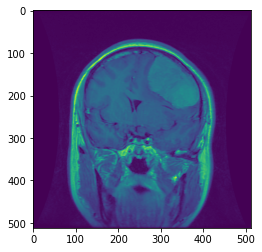

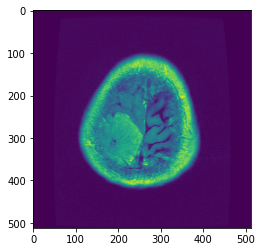

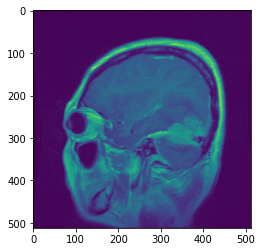

In [69]:
# Label 1 Samples

for i in random.sample(ind_1, 3):
    plt.figure()
    plt.imshow(images[i])

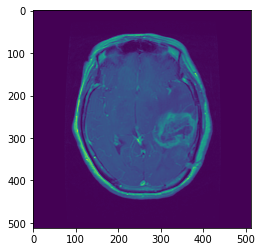

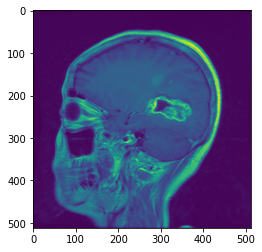

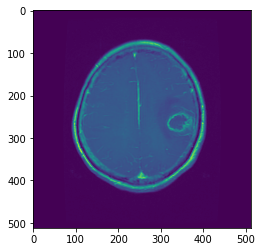

In [70]:
# Label 2 Samples

for i in random.sample(ind_2, 3):
    plt.figure()
    plt.imshow(images[i])

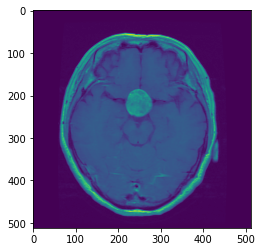

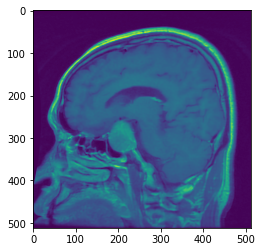

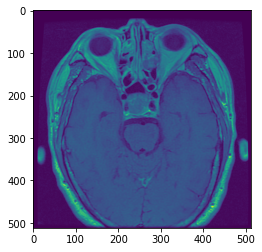

In [71]:
# Label 3 Samples

for i in random.sample(ind_3, 3):
    plt.figure()
    plt.imshow(images[i])

No identifiable differences between the tumor classes so we rely on the supervised model to classify these optimally.

In [72]:
# Shape of images to ensure uniformity
shapes = []
for i in images:
    shapes.append(i.shape[0])

sum(shapes)/len(shapes)
# Not all are the same sizes

510.7467362924282

# Data Processing

In [73]:
# Resizing Images - we can use this as a hyperparameter but for now, let's construct 128x128 pixel images from those we have

width = 128
height = 128

resized_images = []

for i in images:
    resized_images.append(cv2.resize(i, (width, height), interpolation=cv2.INTER_LINEAR))

images = resized_images.copy()

# Also resize tumorMask
resized_tm = []

for i in tumorMask:
    resized_tm.append(cv2.resize(i.astype(float), (width, height), interpolation=cv2.INTER_LINEAR))

tumorMask = resized_tm.copy()

In [74]:
# We can increase the number of samples by created denoised versions of the existing images using a Gaussian blur
# The tumor location does not change so we don't have to worry about fixing the border.

denoised_images = []

# We can use kernel shape as hyperparameter but for now, fixing to (11, 11)
denoising_kernel = (11, 11)

for i in images:
    denoised_images.append(cv2.GaussianBlur(i, denoising_kernel, 0))

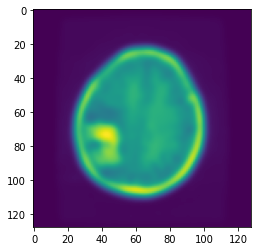

In [75]:
plt.imshow(denoised_images[10])

In [76]:
# We can further remove noise by segmenting the image using thresholding, with 128 as threshold. 
# But first, we should normalize the pixel values in each image from 0 to 255

seg_images = []

for i in denoised_images:
    temp = cv2.normalize(i, i, 0, 255, cv2.NORM_MINMAX)
    seg_images.append(cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)[1])

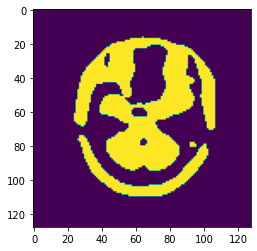

In [77]:
plt.imshow(seg_images[0])

In [78]:
# Let's also create some additional data - rotational, translational transformations

translation_images = []
rot_images = []

for i in images:
    translation_images.append(cv2.warpAffine(i, 
                                          np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]]), 
                                          (i.shape[1], i.shape[0])))
    rot_images.append(ndimage.rotate(i, random.randint(1, 359), reshape = False))

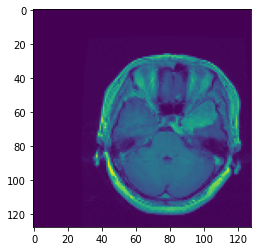

In [79]:
plt.imshow(translation_images[0])

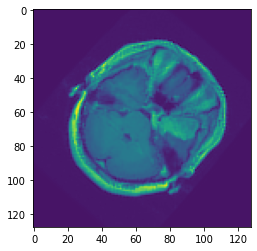

In [80]:
plt.imshow(rot_images[0])

In [81]:
# Finalize which data to use for to build and test the classifier - keep changing to see effect of different preprocessing steps

final = images.copy()
final_labels = labels.copy()

In [82]:
# Split into train and test - use 70% for training and 30% for test

train_test_split = 0.7

# Get indices of each class
ind_1 = []
ind_2 = []
ind_3 = []

for ind in range(len(final_labels)):
    if final_labels[ind] == 1:
        ind_1.append(ind)
    elif final_labels[ind] == 2:
        ind_2.append(ind)
    else:
        ind_3.append(ind)

# Get 70% for each of the classes
def get_train_test(class_list, train_test_split, final, final_labels):
    train = []
    test = []
    train_y = []
    test_y = []
    train_bb = []
    test_bb = []
    
    train_indices = random.sample(class_list, int(np.round(len(class_list)*train_test_split)))
    test_indices = list(set(class_list) - set(train_indices))
    
    for ind in range(len(final)):
        if ind in train_indices:
            train.append(final[ind])
            train_y.append(final_labels[ind])
            train_bb.append(tumorMask[ind])
        elif ind in test_indices:
            test.append(final[ind])
            test_y.append(final_labels[ind])
            test_bb.append(tumorMask[ind])
    return train, test, train_y, test_y, train_bb, test_bb

class_1_res = get_train_test(ind_1, train_test_split, final, final_labels)
class_2_res = get_train_test(ind_2, train_test_split, final, final_labels)
class_3_res = get_train_test(ind_3, train_test_split, final, final_labels)

# Keep Changing Train data adding more preprocessing steps
# I am replicating class 1 and class 3 samples so that during training, they are the same as class 2
train = class_1_res[0]*5 + class_2_res[0] + class_3_res[0]*3 + denoised_images + seg_images
train_y = class_1_res[2]*5 + class_2_res[2] + class_3_res[2]*3 + labels + labels
train_bb = class_1_res[4]*5 + class_2_res[4] + class_3_res[4]*3 + tumorMask + tumorMask

test = class_1_res[1] + class_2_res[1] + class_3_res[1]
test_y = class_1_res[3] + class_2_res[3] + class_3_res[3]
test_bb = class_1_res[5] + class_2_res[5] + class_3_res[5]

# Scale train and test images from 0 to 1, reshape
for t in range(len(train)):
    temp = train[t]
    temp = temp/255
    train[t] = temp.reshape(temp.shape[0], temp.shape[1], 1)
for t in range(len(test)):
    temp = test[t]
    temp = temp/255
    test[t] = temp.reshape(temp.shape[0], temp.shape[1], 1)

In [83]:
# Quality check
print(len(train) == len(train_y))
print(len(test) == len(test_y))

print({x: train_y.count(x) for x in set(train_y)})
print({x: test_y.count(x) for x in set(test_y)})

True
True
{1: 3896, 2: 3850, 3: 3813}
{1: 212, 2: 428, 3: 279}


In [84]:
# Shuffle training data

def shuffle_lists(list1, list2, list3):
    c = list(zip(list1, list2, list3))
    random.shuffle(c)
    list1, list2, list3 = zip(*c)
    return list(list1), list(list2), list(list3)

train, train_y, train_bb = shuffle_lists(train, train_y, train_bb)
test, test_y, test_bb = shuffle_lists(test, test_y, test_bb)

# Convert target arrays into binary arrays
train_y = to_categorical(train_y)[:, 1:]
test_y = to_categorical(test_y)[:, 1:]

In [85]:
# Define the model

def cnn_model(n_nodes_hidden, n_hidden_layers, kernel_size = (3, 3), image_shape = (width, height, 1)):
    model = Sequential()
    model.add(layers.Conv2D(32, kernel_size, activation = 'relu', input_shape = image_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    for h in range(n_hidden_layers):
        model.add(layers.Conv2D(n_nodes_hidden, kernel_size, activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(n_nodes_hidden, kernel_size, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(n_nodes_hidden, activation='relu'))
    model.add(layers.Dense(3, activation = 'softmax'))
    
    return model, model.summary()

model, model_summary = cnn_model(64, 3)
model_summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [86]:
# Fit baseline model

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
fit_model = model.fit(np.array(train), train_y, epochs = 10, verbose = True)

Epoch 1/10
362/362 [==============================] - 282s 771ms/step - loss: 0.6659 - accuracy: 0.7099
Epoch 2/10
362/362 [==============================] - 283s 781ms/step - loss: 0.3899 - accuracy: 0.8372
Epoch 3/10
362/362 [==============================] - 277s 765ms/step - loss: 0.2421 - accuracy: 0.9048
Epoch 4/10
362/362 [==============================] - 286s 790ms/step - loss: 0.1747 - accuracy: 0.9344
Epoch 5/10
362/362 [==============================] - 283s 781ms/step - loss: 0.1100 - accuracy: 0.9576
Epoch 6/10
362/362 [==============================] - 284s 785ms/step - loss: 0.0898 - accuracy: 0.9681
Epoch 7/10
362/362 [==============================] - 290s 801ms/step - loss: 0.0917 - accuracy: 0.9681
Epoch 8/10
362/362 [==============================] - 285s 787ms/step - loss: 0.0468 - accuracy: 0.9849
Epoch 9/10
362/362 [==============================] - 278s 768ms/step - loss: 0.0631 - accuracy: 0.9791
Epoch 10/10
362/362 [==============================] - 283s 783m

In [87]:
# Accuracy of baseline model on test data

model.evaluate(np.array(test), test_y)

29/29 [==============================] - 6s 214ms/step - loss: 0.1960 - accuracy: 0.9619


[0.19598785042762756, 0.961915135383606]

In [89]:
# We want to calculate precision, recall, f1 score per class for train and test

pred_probability_train = model.predict(np.array(train))


In [90]:
predictions_train = np.argmax(pred_probability_train, axis = 1) + 1
actuals_train = np.argmax(train_y, axis = 1) + 1



In [91]:
pred_probability_test = model.predict(np.array(test))
predictions_test = np.argmax(pred_probability_test, axis = 1) + 1
actuals_test = np.argmax(test_y, axis = 1) + 1

In [92]:


for cl in [1, 2, 3]:
    print('Train & Test Precision for class ' + str(cl))
    train_precision = len([i for i,j in zip(list(predictions_train), list(actuals_train)) if i == j == cl])/len([x for x in list(predictions_train) if x == cl])
    print(train_precision)
    test_precision = len([i for i,j in zip(list(predictions_test), list(actuals_test)) if i == j == cl])/len([x for x in list(predictions_test) if x == cl])
    print(test_precision)
    
    print('Train & Test Recall for class ' + str(cl))
    train_recall = len([i for i,j in zip(list(predictions_train), list(actuals_train)) if i == j == cl])/len([x for x in list(actuals_train) if x == cl])
    print(train_recall)
    test_recall = len([i for i,j in zip(list(predictions_test), list(actuals_test)) if i == j == cl])/len([x for x in list(actuals_test) if x == cl])
    print(test_recall)
    
    print('Train & Test F1 Score for class ' + str(cl))
    train_f1 = (2*train_precision*train_recall)/(train_precision + train_recall)
    print(train_f1)
    test_f1 = (2*test_precision*test_recall)/(test_precision + test_recall)
    print(test_f1)
    print('\n')

Train & Test Precision for class 1
0.985544002028912
0.905829596412556
Train & Test Recall for class 1
0.9974332648870636
0.9528301886792453
Train & Test F1 Score for class 1
0.9914529914529915
0.9287356321839081


Train & Test Precision for class 2
0.993202614379085
0.9760191846522782
Train & Test Recall for class 2
0.9867532467532467
0.9509345794392523
Train & Test F1 Score for class 2
0.9899674267100977
0.9633136094674556


Train & Test Precision for class 3
0.9997362173568979
0.985663082437276
Train & Test Recall for class 3
0.993968004196171
0.985663082437276
Train & Test F1 Score for class 3
0.9968437664387165
0.985663082437276




In [94]:
# Now let's automate the process and generate the metrics with hyperparameter tuning

metrics_df = pd.DataFrame()

hidden_nodes_list = [64, 32]
hidden_layers_list = [3, 2, 1]

for i in hidden_nodes_list:
    for j in hidden_layers_list:
        model, model_summary = cnn_model(i, j)
        
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        model.fit(np.array(train), train_y, epochs = 5, verbose = True)
        
        train_acc = model.evaluate(np.array(train), train_y)[1]
        test_acc = model.evaluate(np.array(test), test_y)[1]
        
        # Compile all important information in 1 dataframe
        per_model_df = pd.DataFrame({'n_nodes_hidden': i,
                                     'n_hidden_layers': j,
                                     'acc_train': train_acc,
                                     'acc_test': test_acc}, index = [0])
        
        # We want to calculate precision, recall, f1 score per class for train and test

        pred_probability_train = model.predict(np.array(train))
        predictions_train = np.argmax(pred_probability_train, axis = 1) + 1
        actuals_train = np.argmax(train_y, axis = 1) + 1

        pred_probability_test = model.predict(np.array(test))
        predictions_test = np.argmax(pred_probability_test, axis = 1) + 1
        actuals_test = np.argmax(test_y, axis = 1) + 1
        
        for cl in [1, 2, 3]:
            train_precision = len([i for i,j in zip(list(predictions_train), list(actuals_train)) if i == j == cl])/len([x for x in list(predictions_train) if x == cl])
            per_model_df['train_' + str(cl) + '_prec'] = [train_precision]
            test_precision = len([i for i,j in zip(list(predictions_test), list(actuals_test)) if i == j == cl])/len([x for x in list(predictions_test) if x == cl])
            per_model_df['test_' + str(cl) + '_prec'] = [test_precision]

            train_recall = len([i for i,j in zip(list(predictions_train), list(actuals_train)) if i == j == cl])/len([x for x in list(actuals_train) if x == cl])
            per_model_df['train_' + str(cl) + '_rec'] = [train_recall]
            test_recall = len([i for i,j in zip(list(predictions_test), list(actuals_test)) if i == j == cl])/len([x for x in list(actuals_test) if x == cl])
            per_model_df['test_' + str(cl) + '_rec'] = [test_recall]

            train_f1 = (2*train_precision*train_recall)/(train_precision + train_recall)
            per_model_df['train_' + str(cl) + '_f1'] = [train_f1]
            test_f1 = (2*test_precision*test_recall)/(test_precision + test_recall)
            per_model_df['test_' + str(cl) + '_f1'] = [test_f1]
        
        metrics_df = metrics_df.append(per_model_df)
        print('Done')

metrics_df

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 64)      

,n_nodes_hidden,n_hidden_layers,acc_train,acc_test,train_1_prec,test_1_prec,train_1_rec,test_1_rec,train_1_f1,test_1_f1,...,train_2_rec,test_2_rec,train_2_f1,test_2_f1,train_3_prec,test_3_prec,train_3_rec,test_3_rec,train_3_f1,test_3_f1
0,64,3,0.978285,0.924918,0.977760,0.799180,0.959189,0.919811,0.968386,0.855263,...,0.976104,0.880841,0.969431,0.920635,0.994523,0.978873,1.000000,0.996416,0.997254,0.987567
0,64,2,0.982871,0.943417,0.956393,0.871560,0.996407,0.896226,0.975990,0.883721,...,0.954545,0.934579,0.974155,0.941176,0.999737,0.992832,0.997640,0.992832,0.998687,0.992832
0,64,1,0.984255,0.956474,0.992604,0.892857,0.964579,0.943396,0.978391,0.917431,...,0.993766,0.941589,0.979895,0.956109,0.994494,0.985714,0.994755,0.989247,0.994624,0.987478
0,32,3,0.962973,0.906420,0.918005,0.750943,0.982803,0.938679,0.949300,0.834382,...,0.918182,0.845794,0.947086,0.899379,0.998410,0.981949,0.987936,0.974910,0.993145,0.978417
0,32,2,0.975603,0.908596,0.939320,0.733096,0.993326,0.971698,0.965569,0.835700,...,0.935325,0.822430,0.963607,0.900256,0.997641,0.975352,0.998164,0.992832,0.997902,0.984014
0,32,1,0.986418,0.958651,0.986469,0.889381,0.973049,0.948113,0.979713,0.917808,...,0.986494,0.939252,0.980762,0.958284,0.997906,0.985816,1.000000,0.996416,0.998952,0.991087


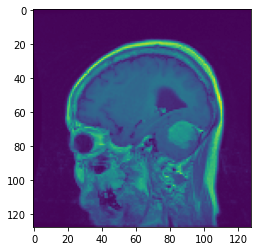

In [95]:
plt.imshow(train[-2][:, :, 0])

In [96]:
metrics_df.to_excel('Raw_Denoise_Seg_Upsample.xlsx', index = False)

# Tumor Localization

In [97]:
# For tumor localization, we will use the balanced training data from before with raw, denoised and segmented images

# First, we must modify the masked images into a proper output that can be predicted. We convert the boundaries into bounding 
# boxes
# The target will be np.array([bb_mid_x, bb_mid_y, bb_height, bb_width, class_1_binary, class_2_binary, class_3_binary])

height = 128
width = 128

def get_bb_targets(train_bb, train_y):
    train_loc = []
    for ind in range(len(train_bb)):
        left_boundary = np.where(train_bb[ind].astype(int).sum(axis = 0) > 0)[0][0]
        right_boundary = np.where(train_bb[ind].astype(int).sum(axis = 0) > 0)[0][-1]
        top_boundary = np.where(train_bb[ind].astype(int).sum(axis = 1) > 0)[0][0]
        bottom_boundary = np.where(train_bb[ind].astype(int).sum(axis = 1) > 0)[0][-1]

        cl = list(train_y[ind])

        target = [(top_boundary + bottom_boundary)/(2*height), 
                  (left_boundary + right_boundary)/(2*width), 
                  (bottom_boundary - top_boundary)/height, (right_boundary - left_boundary)/width] + cl

        train_loc.append(np.array(target))
    return np.array(train_loc)

train_loc = get_bb_targets(train_bb, train_y)
test_loc = get_bb_targets(test_bb, test_y)

In [98]:
# Define the tumor localization model

def loc_model(n_nodes_hidden, n_hidden_layers, kernel_size = (3, 3), image_shape = (width, height, 1)):
    model = Sequential()
    model.add(layers.Conv2D(32, kernel_size, activation = 'elu', input_shape = image_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    for h in range(n_hidden_layers):
        model.add(layers.Conv2D(n_nodes_hidden, kernel_size, activation='elu'))
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(n_nodes_hidden, kernel_size, activation='elu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(n_nodes_hidden, activation='elu'))
    model.add(layers.Dense(7, activation = 'sigmoid'))
    
    return model, model.summary()

model, model_summary = loc_model(64, 2)
model_summary

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 14, 14, 64)      

In [99]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
fit_model = model.fit(np.array(train), train_loc, epochs = 5, use_multiprocessing = True, verbose = True)

Epoch 1/5
362/362 [==============================] - 321s 886ms/step - loss: 0.4567 - accuracy: 0.6930
Epoch 2/5
362/362 [==============================] - 326s 901ms/step - loss: 0.3787 - accuracy: 0.8734
Epoch 3/5
362/362 [==============================] - 330s 911ms/step - loss: 0.3442 - accuracy: 0.9354
Epoch 4/5
362/362 [==============================] - 327s 902ms/step - loss: 0.3285 - accuracy: 0.9623
Epoch 5/5
362/362 [==============================] - 331s 914ms/step - loss: 0.3211 - accuracy: 0.9740


In [100]:
train_predlocs = model.predict(np.array(train))
test_predlocs = model.predict(np.array(test))

In [101]:
class_predictions_train = np.argmax(train_predlocs[:, 4:], axis = 1) + 1
class_actuals_train = np.argmax(train_y, axis = 1) + 1
class_predictions_test = np.argmax(test_predlocs[:, 4:], axis = 1) + 1
class_actuals_test = np.argmax(test_y, axis = 1) + 1

bb_predictions_train = train_predlocs[:, :4]
bb_actuals_train = train_loc[:, :4]
bb_predictions_test = test_predlocs[:, :4]
bb_actuals_test = test_loc[:, :4]

In [102]:
# Calculate class accuracy for train and test

train_acc = 0
for ind in range(len(class_predictions_train)):
    if class_predictions_train[ind] == class_actuals_train[ind]:
        train_acc += 1

print('Train Accuracy for Classes: ' + str(train_acc/len(class_predictions_train)))

test_acc = 0
for ind in range(len(class_predictions_test)):
    if class_predictions_test[ind] == class_actuals_test[ind]:
        test_acc += 1

print('Test Accuracy for Classes: ' + str(test_acc/len(class_predictions_test)))

Train Accuracy for Classes: 0.9809672116965136
Test Accuracy for Classes: 0.9684439608269858


In [103]:
# Calculate bounding box error for train and test - mean absolute error for size of box and coordinates

# Size of box
print('Train error on size of box: ' + str(np.mean(np.abs(bb_predictions_train[:,2:4] - bb_actuals_train[:,2:4]))*128))
print('Test error on size of box: ' + str(np.mean(np.abs(bb_predictions_test[:,2:4] - bb_actuals_test[:,2:4]))*128))
print('\n')

# Midpoint coordinates
print('Train error on midpoint coordinates: ' + str(np.mean(np.abs(bb_predictions_train[:,:2] - bb_actuals_train[:,:2]))*128))
print('Test error on midpoint coordinates: ' + str(np.mean(np.abs(bb_predictions_test[:,:2] - bb_actuals_test[:,:2]))*128))

Train error on size of box: 5.147623298097847
Test error on size of box: 6.4859402524763405


Train error on midpoint coordinates: 8.319131374482888
Test error on midpoint coordinates: 9.973384788687522


In [113]:
# Export the test images with the bounding boxes and class

for ind in range(len(test)):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(test[ind][:,:,0])

    lower_corner = ((bb_predictions_test[ind][1] - bb_predictions_test[ind][3]/2)*128, 
                    (bb_predictions_test[ind][0] - bb_predictions_test[ind][2]/2)*128)

    # Create a Rectangle patch
    rect = patches.Rectangle(lower_corner, bb_predictions_test[ind][3]*128, 
                             bb_predictions_test[ind][2]*128, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
    # Class of Image
    cl = class_predictions_test[ind]
    
    # Export to appropriate folder
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/test_images/'+str(cl)+'/'+str(ind)+'.png')
    plt.close()